In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Setup output and imports
from tslib import ts_import, ts_output, ts_log, ts_csvout
PROG = "deflect-gate-pplate" # This experiment's ID
OUT_D = ts_output(PROG)      # Output file directory
LIB_V = "20211004"           # Requested library version

# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt

libem = ts_import("libem", LIB_V)
cmp = ts_import("components", LIB_V)
rlm = ts_import("realmodel", LIB_V)
libvis = ts_import("libvis", LIB_V)

Creating results directory: results\deflect-gate-pplate20211006


## Set up dimensions and conversions

In [3]:
conv = rlm.Conversion(
    mass=1, # kg (1amu) / sim unit
    length=1, #1cm / sim unit
    time=1,
    charge=1,
    voltage=1
)

# Goal for deflection voltage is 10V for 200eV ions

DFDIM = {
    "length": conv.real_to_sim(3, "length"), # ideal is 3cm
    "box": conv.real_to_sim(2, "length"),
    "diam": conv.real_to_sim(1, "length"),
    "boxwall": conv.real_to_sim(0.2, "length"),

    "panel_l": conv.real_to_sim(1, "length"),
    "panel_w": conv.real_to_sim(1.6, "length"),
    "panel_h": conv.real_to_sim(0.2, "length"),
    "panel_gap": conv.real_to_sim(1.1, "length")
}

set_panel_sheight = lambda h: h - (DFDIM["box"] / 2.0)

SPACE_SIZE = [round(DFDIM["length"] * 1.5), round(DFDIM["box"] * 1.5), round(DFDIM["box"] * 1.5)]
SPACE_TLFT = [-(s / 2.0) for s in SPACE_SIZE]

SCALE = 10

ts_log(PROG, "SIMULATION SPACE SIZE:", ", ".join([str(s) for s in SPACE_SIZE]))
ts_log(PROG, "SIMULATION SPACE TOP_LEFT:", ", ".join([str(tl) for tl in SPACE_TLFT]))
ts_log(PROG, "SIMULATION SCALE SET AT:", SCALE)


SIMULATION SPACE SIZE: 4, 3, 3
SIMULATION SPACE TOP_LEFT: -2.0, -1.5, -1.5
SIMULATION SCALE SET AT: 10


## Gate generator

In [4]:
def generate_dfgate(panel_pos, body_V, hole_V, electrode_V):
    # Create simulation space from global parameters
    sim = libem.EMSimulationSpace3D(space_size=SPACE_SIZE, top_left=SPACE_TLFT, scale=SCALE)

    # CREATE GATE COMPONENTS
    # Body - Hollow Rectangular Prism
    body = (
        (-(DFDIM["length"] / 2.0), -(DFDIM["box"] / 2.0), -(DFDIM["box"] / 2.0)),
        (DFDIM["length"], DFDIM["box"], DFDIM["box"]),
        DFDIM["boxwall"],
        body_V
    )
    # End Holes - Closed Cylinders
    ehole_0_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        (-(DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0
    )
    ehole_1_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        ((DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0,
        direction=-1
    )
    # Deflection Panel - Rectangular Prism
    top_panel = (
        (*panel_pos[:2], panel_pos[2] + DFDIM["panel_gap"]),
        (DFDIM["panel_l"], DFDIM["panel_w"], DFDIM["panel_h"]),
        -electrode_V
    )
    bottom_panel = (
        panel_pos,
        (DFDIM["panel_l"], DFDIM["panel_w"], DFDIM["panel_h"]),
        electrode_V
    )

    # Generate boundary enforcer
    enf = cmp.make_enforcer(
        cmp.enf(cmp.EMObjects.rectangular_prism_hollow, *body),
        cmp.enf(cmp.EMObjects.arbitrary_mask, ehole_0_mask, hole_V),
        cmp.enf(cmp.EMObjects.arbitrary_mask, ehole_1_mask, hole_V),
        cmp.enf(cmp.EMObjects.rectangular_prism_solid, *top_panel),
        cmp.enf(cmp.EMObjects.rectangular_prism_solid, *bottom_panel)
    )

    return sim, enf


## Visualize

Visualizing the deflection gate
 - Computing electric field
 - Rendering 3D Electric Field


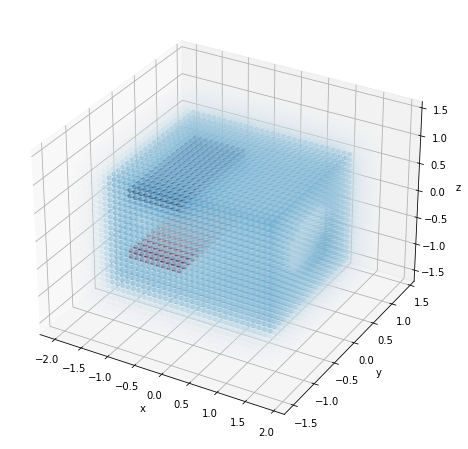

 - Rendering 2D Electric Field Cross-Sections at 0


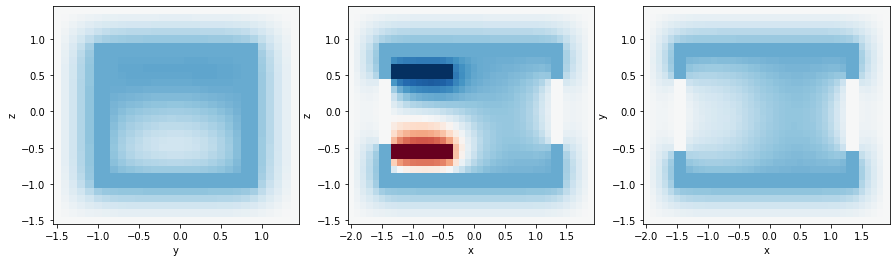

In [5]:
def visualize_dfgate(panel_pos, body_V, hole_V, electrode_V):
    V_norm = max(abs(electrode_V), abs(hole_V), abs(body_V), 1)

    print("Visualizing the deflection gate")
    sim, enf = generate_dfgate(panel_pos, body_V, hole_V, electrode_V)
    print(" - Computing electric field")
    sim.compute(enf)
    print(" - Rendering 3D Electric Field")

    libvis.Visualizations.colormesh_3d(sim, size=(10, 8), resolution=1, color_norm=V_norm)

    print(" - Rendering 2D Electric Field Cross-Sections at 0")

    _, axs = plt.subplots(1, 3, figsize=(15, 4))
    labels = ["x", "y", "z"]
    for i, ax in enumerate(axs):
        sub_label = labels[:]
        sub_label.pop(i)
        ax.set_xlabel(sub_label[0])
        ax.set_ylabel(sub_label[1])

        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
        libvis.Visualizations.colormesh_2d(sim2d, color_norm=V_norm, graph_ax=ax)

visualize_dfgate(
    (-(DFDIM["length"] / 2.0) + DFDIM["boxwall"], -(DFDIM["box"] / 2.0) + DFDIM["boxwall"], set_panel_sheight(0.4)),
    #(-(DFDIM["panel_l"] / 2.0), -(DFDIM["panel_w"] / 2.0), (set_panel_sheight(DFDIM["box"] / 2.0))),
    0.5, 0, -1
)


## Visualize Particle Path

Visualizing the deflection gate with particle path.
 - Computing electric field
 - Computing particle motion
 - Rendering 2D Electric Field Cross-Sections at 0 with Motion
Particle path experiment ran.


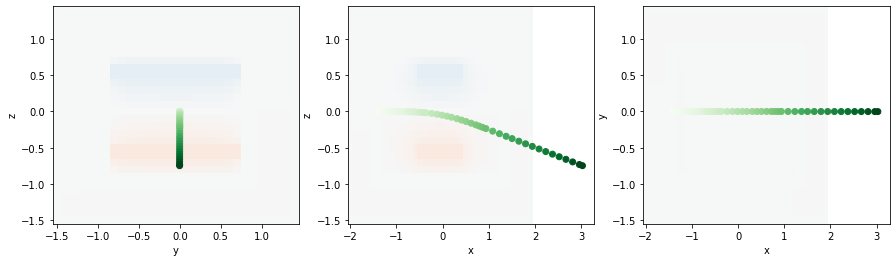

In [7]:
PARTICLE_OPTS = {
    "mass": (conv.real_to_sim(1, "mass"), 0),
    "charge": (conv.real_to_sim(1, "charge"), 0),
    "initial_loc": ((conv.real_to_sim(-1.4, "length"), 0, 0), (0, 0, 0)),
    "initial_v": ((conv.real_to_sim(1, "length / time"), 0, 0), (0, 0, 0)),
    "bounce_coef": None
}

def visualize_dfgate_particle(particle_opts, panel_pos, body_V, hole_V, electrode_V):
    V_norm = max(abs(electrode_V), abs(hole_V), abs(body_V), 1)

    print("Visualizing the deflection gate with particle path.")
    sim, enf = generate_dfgate(panel_pos, body_V, hole_V, electrode_V)
    print(" - Computing electric field")
    sim.compute(enf)
    sim.get_efield()
    print(" - Computing particle motion")
    particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                       (particle_opts["initial_loc"][0][0], 0, 0),
                                       particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
    particle.compute_motion((0, (DFDIM["length"] * 1.5) / particle_opts["initial_v"][0][0]))
    print(" - Rendering 2D Electric Field Cross-Sections at 0 with Motion")

    _, axs = plt.subplots(1, 3, figsize=(15, 4))
    labels = ["x", "y", "z"]
    for i, ax in enumerate(axs):
        sub_label = labels[:]
        sub_label.pop(i)
        ax.set_xlabel(sub_label[0])
        ax.set_ylabel(sub_label[1])

        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
        libvis.Visualizations.colormesh_2d(sim2d, color_norm=V_norm, graph_ax=ax)
        libvis.Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)

    # Save the simulation results
    # Columns: MASS, CHARGE, X_0, Vx_0, Vy_0, Vz_0, BOUNCE, X_1, Y_1, Z_1
    ts_csvout(PROG, "particle_paths.csv",
        [particle_opts["mass"][0], particle_opts["charge"][0], particle_opts["initial_loc"][0][0], *particle_opts["initial_v"][0],
        particle_opts["bounce_coef"], *particle.position.T[-1]]
    )
    # Save image
    plt.savefig(OUT_D + "/ppath.png")
    # Log
    ts_log(PROG, "Particle path experiment ran.")


visualize_dfgate_particle(
    PARTICLE_OPTS,
    (-(DFDIM["panel_l"] / 2.0), -(DFDIM["panel_w"] / 2.0), (set_panel_sheight(0.4))),
    0, 0, -0.1
)
